In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))

['train.csv', 'sample.csv', 'test.csv']


In [2]:
from tqdm import tqdm_notebook
import torch
import fastai
from fastai.text import *
fastai.__version__

'1.0.54'

In [3]:
path = Path('../input')

In [4]:
train = pd.read_csv('../input/train.csv').fillna(' ')
test = pd.read_csv('../input/test.csv').fillna(' ')


In [5]:
pd.concat([train['text'], test['text']]).to_csv(
    'unlabeled.csv', index=None, header=True)

In [6]:
folder = '.'
unlabeled_file = 'unlabeled.csv'

In [7]:


%%time
data_lm = TextLMDataBunch.from_csv(folder, unlabeled_file, text_cols='text')

CPU times: user 2.69 s, sys: 324 ms, total: 3.02 s
Wall time: 35.1 s


In [8]:
%%time
learn = language_model_learner(data_lm, drop_mult=0.3, arch=AWD_LSTM, pretrained=True)

CPU times: user 6.18 s, sys: 1.62 s, total: 7.8 s
Wall time: 11.1 s


In [9]:
%%time
learn.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 3.97 s, sys: 10.6 s, total: 14.6 s
Wall time: 15.9 s


Min numerical gradient: 2.24E-02
Min loss divided by 10: 1.26E-02


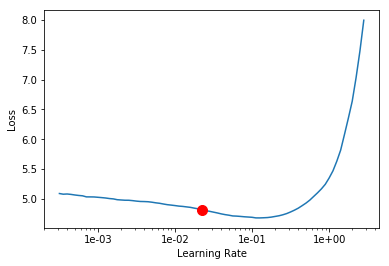

In [10]:
learn.recorder.plot(skip_end=10, suggestion=True)
best_lm_lr = learn.recorder.min_grad_lr

In [11]:
%%time
learn.fit_one_cycle(1, best_lm_lr)

epoch,train_loss,valid_loss,accuracy,time
0,3.726254,3.432604,0.370118,01:47


CPU times: user 28.5 s, sys: 1min 20s, total: 1min 48s
Wall time: 1min 47s


In [12]:
%%time
learn.unfreeze()
learn.fit_one_cycle(3, best_lm_lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.001579,4.053214,0.306054,02:05
1,3.617733,3.552524,0.366190,02:05
2,3.168648,3.259802,0.410083,02:05


CPU times: user 1min 40s, sys: 4min 41s, total: 6min 21s
Wall time: 6min 17s


In [13]:
learn.save_encoder('medical_enc')

In [14]:
!cp ../input/test.csv .
!cp ../input/train.csv .

In [15]:
Counter(data_clas.train_ds.y.items)

NameError: name 'data_clas' is not defined

In [16]:
data_clas = TextClasDataBunch.from_csv(path=folder, 
                                        csv_name='train.csv',
                                        test='test.csv',
                                        vocab=data_lm.train_ds.vocab, 
                                        bs=64,
                                        text_cols='text', 
                                        label_cols='sentiment')

In [17]:
learn_clas = text_classifier_learner(data_clas, drop_mult=0.3, arch=AWD_LSTM)
# learn_clas.load_encoder('medical_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.78E-01
Min loss divided by 10: 2.00E-02


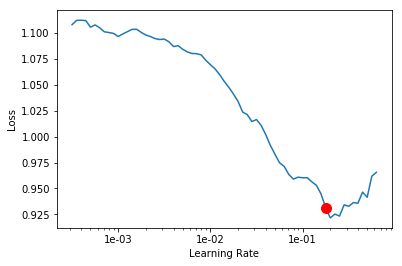

In [18]:
learn_clas.lr_find(start_lr=slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn_clas.recorder.plot(skip_end=10, suggestion=True)
best_clf_lr = learn_clas.recorder.min_grad_lr

In [19]:
learn_clas.fit_one_cycle(3, best_clf_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.855613,0.821457,0.732008,01:00
1,0.834434,0.895102,0.732008,01:02
2,0.803701,0.765832,0.732008,01:01


In [20]:
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(1, best_clf_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.807185,0.764361,0.732008,01:00


In [21]:
learn_clas.fit_one_cycle(3, best_clf_lr)
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(1, best_clf_lr)
learn_clas.unfreeze()
learn_clas.fit_one_cycle(1, best_clf_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.834143,8851.103516,0.153409,00:54
1,0.825485,0.790456,0.732008,01:04
2,0.791469,0.762144,0.732008,00:56


epoch,train_loss,valid_loss,accuracy,time
0,0.824569,0.763707,0.732008,00:53


epoch,train_loss,valid_loss,accuracy,time
0,0.820842,1.598272,0.731061,01:29


In [22]:
learn_clas.show_results()

text,target,prediction
xxbos xxup serious xxup infections xxmaj patients treated with xxmaj remicade ® are at increased risk for developing serious infections that may lead to hospitalization or death [ see xxmaj warnings and xxmaj precautions ( 5.1 ) and xxmaj adverse xxmaj reactions ( 6.1 ) ] . xxmaj most patients who developed these infections were taking concomitant immunosuppressants such as methotrexate or corticosteroids . xxmaj remicade should be discontinued if,2,2
"xxbos xxmaj written xxmaj january 12 , 2018 xxmaj next : xxmaj let xxmaj us xxmaj try xxmaj home xxmaj ratings xxmaj rate this xxmaj summary xxmaj current xxmaj average xxmaj ratings xxmaj overall quality xxmaj avg : 0 / 5 xxmaj applies to topic xxmaj avg : 0 / 5 xxmaj helpful to me xxmaj avg : 0 / 5 xxmaj underwhelmed xxmaj total xxmaj avg xxmaj rating :",2,2
xxbos m protein xxmaj an antibody or part of an antibody found in unusually large amounts in the blood or urine of people with multiple myeloma and other types of plasma cell tumors . xxmaj also called monoclonal protein . m - xxup edta xxmaj minocycline - xxup edta . a substance being studied in the treatment of bacterial infections from catheters ( flexible tubes used to deliver fluids into,2,2
xxbos xxmaj childhood soft tissue sarcoma is a disease in which malignant ( cancer ) cells form in soft tissues of the body . xxmaj soft tissue sarcoma occurs in children and adults . xxmaj having certain diseases and inherited disorders can increase the risk of childhood soft tissue sarcoma . xxmaj the most common sign of childhood soft tissue sarcoma is a painless lump or swelling in soft tissues,2,2
"xxbos xxmaj the lungs are a pair of cone - shaped breathing organs in the chest . xxmaj the lungs bring oxygen into the body as you breathe in . xxmaj they release carbon dioxide , a waste product of the body ’s cells , as you breathe out . xxmaj each lung has sections called lobes . xxmaj the left lung has two lobes . xxmaj the right lung",2,2


In [23]:
data_clas.add_test(test["text"])
test_preds, _ = learn_clas.get_preds(DatasetType.Test,ordered=True)

In [24]:
test_preds.data.cpu().numpy()

array([[0.146043, 0.132549, 0.721408],
       [0.146068, 0.132564, 0.721368],
       [0.146246, 0.132671, 0.721083],
       [0.146285, 0.132694, 0.721021],
       ...,
       [0.146258, 0.13268 , 0.721062],
       [0.146255, 0.132676, 0.721069],
       [0.14654 , 0.132846, 0.720614],
       [0.146328, 0.132719, 0.720953]], dtype=float32)

In [25]:
test_pred_df = pd.DataFrame(test_preds.data.cpu().numpy(),
                            columns=['positive', 'negative', 'neutral'])
ulmfit_preds = pd.Series(np.argmax(test_pred_df.values, axis=1),
                        name='label')



In [26]:
test_pred_df

,positive,negative,neutral
0,0.146043,0.132549,0.721408
1,0.146068,0.132564,0.721368
2,0.146246,0.132671,0.721083
3,0.146285,0.132694,0.721021
4,0.146491,0.132817,0.720692
5,0.146150,0.132614,0.721236
6,0.146768,0.132983,0.720249
7,0.146238,0.132666,0.721096
8,0.146266,0.132683,0.721052
9,0.146165,0.132622,0.721213


In [27]:
from collections import Counter

In [28]:
Counter(ulmfit_preds)

Counter({2: 2924})